**Project Purpose:**

This project is a mask detection system using deep learning with transfer learning. Its primary goal is to build a model capable of classifying people wearing masks and those not wearing masks using facial images. We use a MobileNetV2 network pre-trained on the ImageNet dataset and then add specialized layers to adapt the model to the specific mask detection task.

**Import libraries**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

**Load Data**

In [2]:
with_mask_path = '/kaggle/input/face-mask-dataset/data/with_mask/'
without_mask_path = '/kaggle/input/face-mask-dataset/data/without_mask/'

In [3]:
with_mask_files = os.listdir(with_mask_path)
without_mask_files = os.listdir(without_mask_path)

**Creating Labels for the two class of Images**

with mask --> 1

without mask --> 0

In [4]:
with_mask_labels = [1]*len(with_mask_files)
without_mask_labels = [0]*len(without_mask_files)

In [5]:
print(with_mask_labels[0:5])
print(without_mask_labels[0:5])

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [6]:
labels = with_mask_labels + without_mask_labels
print(len(labels))

7553


**Displaying with Mask Image**

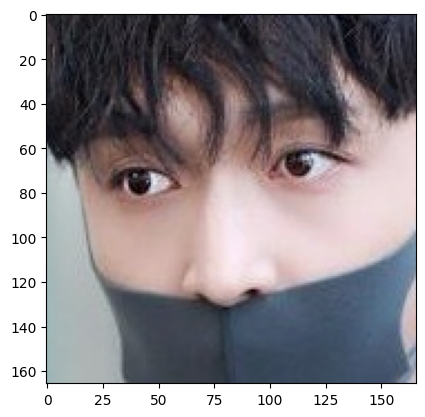

In [7]:
img = mpimg.imread('/kaggle/input/face-mask-dataset/data/with_mask/with_mask_1005.jpg')
imgplot = plt.imshow(img)
plt.show()

**Displaying without Mask Image**

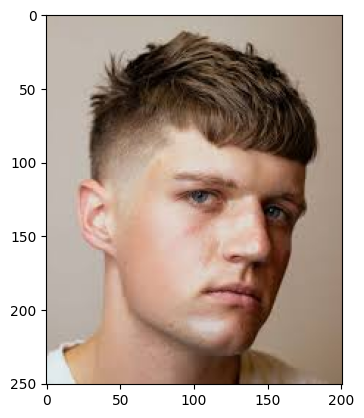

In [8]:
#displaying without mask image
img = mpimg.imread('/kaggle/input/face-mask-dataset/data/without_mask/without_mask_1017.jpg')
imgplot = plt.imshow(img)
plt.show()

**Image Processing**

Resize the Images

Convert the images to numpy arrays

In [9]:
data = []
def load_images_from_folder(folder_path, files):
    for img_file in files:
        try:
            image = Image.open(folder_path + img_file).resize((224, 224)).convert('RGB')
            data.append(np.array(image))
        except Exception as e:
            print(f"Error loading {img_file}: {e}")

In [10]:
load_images_from_folder(with_mask_path, with_mask_files)
load_images_from_folder(without_mask_path, without_mask_files)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
X = np.array(data)
Y = np.array(labels)

**Train/Test split**

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
X_train = X_train / 255.0
X_test = X_test / 255.0


**Transfer Learning with MobileNetV2**

In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False

<ipython-input-13-bdcffaa0cd7f>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Build model**

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


**Train the model**

In [16]:
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=5, batch_size=32)

Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 132s 744ms/step - accuracy: 0.7286 - loss: 0.6205 - val_accuracy: 0.9686 - val_loss: 0.0797
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 126s 741ms/step - accuracy: 0.9429 - loss: 0.1549 - val_accuracy: 0.9851 - val_loss: 0.0486
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 134s 788ms/step - accuracy: 0.9623 - loss: 0.1110 - val_accuracy: 0.9884 - val_loss: 0.0393
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 127s 748ms/step - accuracy: 0.9670 - loss: 0.1000 - val_accuracy: 0.9934 - val_loss: 0.0351
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 143s 754ms/step - accuracy: 0.9730 - loss: 0.0786 - val_accuracy: 0.9901 - val_loss: 0.0341


**Evaluate model**

In [17]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Accuracy =', accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 658ms/step - accuracy: 0.9912 - loss: 0.0259
Test Accuracy = 0.9920582175254822


**plot the loss value**

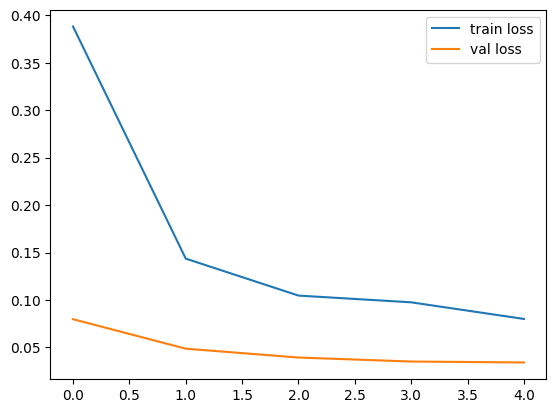

In [18]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

**plot the accuracy value**

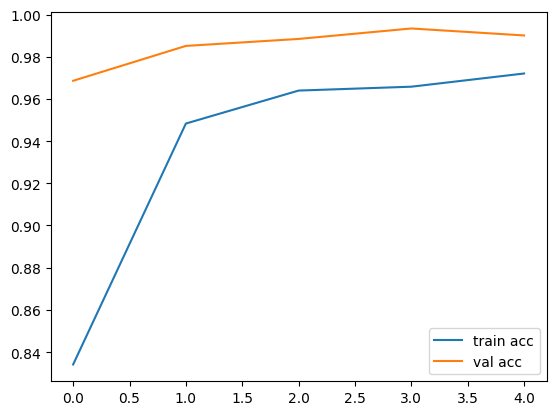

In [19]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**Predictive System**

In [20]:
input_image_path = input('Path of the image to be predicted: ') 

input_image = Image.open(input_image_path)  
input_image = input_image.resize((224, 224))

input_image_scaled = np.array(input_image) / 255.0
input_image_reshaped = np.reshape(input_image_scaled, [1, 224, 224, 3])

input_prediction = model.predict(input_image_reshaped)
input_pred_label = np.argmax(input_prediction)

if input_pred_label == 1:
    print('The person in the image is wearing a mask')
else:
    print('The person in the image is not wearing a mask')



StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.